In [36]:

import os
scenario_name = "scenario-1"

files = os.listdir(f"results/{scenario_name}")
# filter only files with "metrics" in name
files_metrics = [f for f in files if "metrics" in f]
files_results = [f for f in files if "results" in f]
files_metrics.sort()
files_results.sort()
filename_metrics = f"results/{scenario_name}/{files_metrics[-1]}"
filename_results = f"results/{scenario_name}/{files_results[-1]}"

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(filename_metrics, header=None, names=[
                 'Timestamp', 'Cluster', 'Stage', 'Metric', 'Value', 'Details'])
first_timestamps = df.groupby('Stage').first()
# first_timestamps to x-axis unit
first_timestamps['Timestamp'] = pd.to_datetime(first_timestamps['Timestamp'])

/var/folders/p8/rwx4ydq51ss_q1q3rbrqktjw0000gn/T/ipykernel_55808/1237917492.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Timestamp'] = pd.to_datetime(filtered_df['Timestamp'])


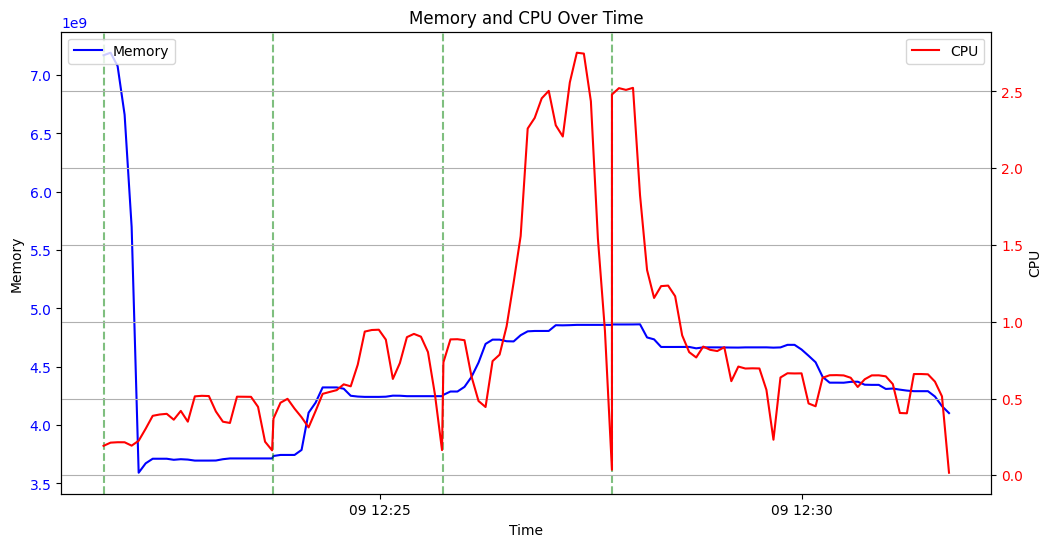

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame to include 'memory' and 'cpu' metrics
filtered_df = df[df['Metric'].isin(['memory', 'cpu'])]

# Convert the 'Timestamp' column to datetime format
filtered_df['Timestamp'] = pd.to_datetime(filtered_df['Timestamp'])

# Set 'Timestamp' column as the DataFrame index
filtered_df.set_index('Timestamp', inplace=True)


# Create separate subplots for memory and CPU
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot memory values
memory_df = filtered_df[filtered_df['Metric'] == 'memory']
ax1.plot(memory_df.index, memory_df['Value'], label='Memory', color='b')
ax1.set_ylabel('Memory')
ax1.tick_params(axis='y', labelcolor='b')

# Plot CPU values
cpu_df = filtered_df[filtered_df['Metric'] == 'cpu']
ax2.plot(cpu_df.index, cpu_df['Value'], label='CPU', color='r')
ax2.set_ylabel('CPU')
ax2.tick_params(axis='y', labelcolor='r')

# For each row in first_timestamps draw vertical line at the "Timestamp" value
for index, row in first_timestamps.iterrows():
    ax1.axvline(row['Timestamp'], linestyle='--', color='g', alpha=0.5)

ax1.set_xlabel('Time')
plt.title('Memory and CPU Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()

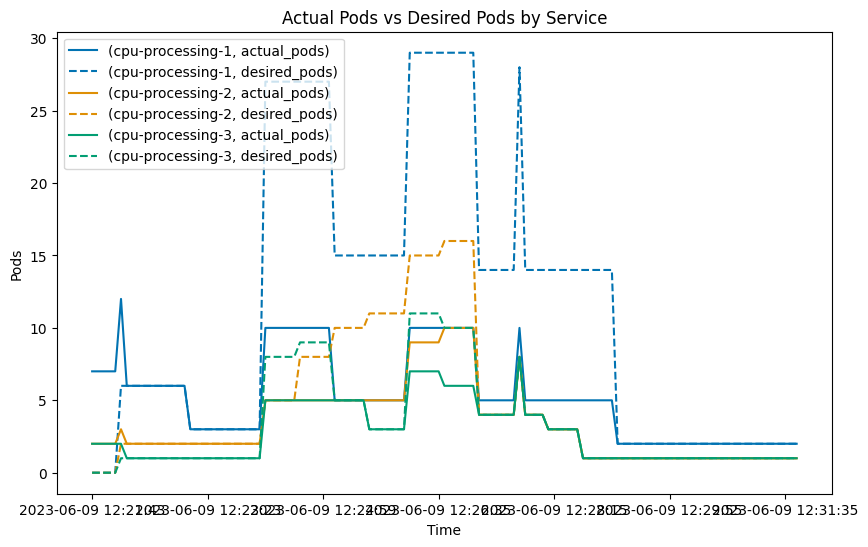

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(filename_metrics, header=None, names=[
                 'Timestamp', 'Cluster', 'Stage', 'Metric', 'Value', 'Details'])

# Set column names

column_names = ['timestamp', 'cluster', 'stage', 'metric', 'value', 'metadata']
df.columns = column_names

filter_metrics = ['desired_pods', 'actual_pods']
df = df[df['metric'].isin(filter_metrics)]

# Set column names
column_names = ['timestamp', 'cluster', 'stage', 'metric', 'value', 'metadata']
df.columns = column_names

filter_metrics = ['desired_pods', 'actual_pods']
df = df[df['metric'].isin(filter_metrics)]
# Extract relevant information from the metadata column
df['metadata'] = df['metadata'].str.strip('""')
df['configuration_name'] = df['metadata'].str.extract(
    "'configuration_name': '([^']+)'")
df['revision_name'] = df['metadata'].str.extract("'revision_name': '([^']+)'")
df['service_name'] = df['metadata'].str.extract("'service_name': '([^']+)'")

filtered_df = df[df['metric'].isin(['actual_pods', 'desired_pods'])]

# Group by timestamp and service_name, and sum the values
grouped_df = filtered_df.groupby(['timestamp', 'service_name', 'metric'])[
    'value'].sum().reset_index()

# Pivot the dataframe to have service_name as separate columns
pivoted_df = grouped_df.pivot(index='timestamp', columns=[
                              'service_name', 'metric'], values='value')


# Plot the data
ax = pivoted_df.plot(kind='line', figsize=(10, 6))

# Assign the same color to all metrics within the same service
service_names = pivoted_df.columns.get_level_values(0).unique()
colors = sns.color_palette("colorblind", n_colors=len(service_names))

for i, service_name in enumerate(service_names):
    metrics = pivoted_df[service_name].columns
    for metric in metrics:
        ax.lines[pivoted_df.columns.get_loc(
            (service_name, metric))].set_color(colors[i])


# Customize the line styles for each metric
desired_pods_cols = [(col[0], col[1])
                     for col in pivoted_df.columns if col[1] == 'desired_pods']
for col in desired_pods_cols:
    ax.lines[pivoted_df.columns.get_loc(col)].set_linestyle('--')

plt.xlabel('Time')
plt.ylabel('Pods')
plt.title('Actual Pods vs Desired Pods by Service')


# Set the legend labels as the service names
ax.legend(loc='upper left')
plt.show()

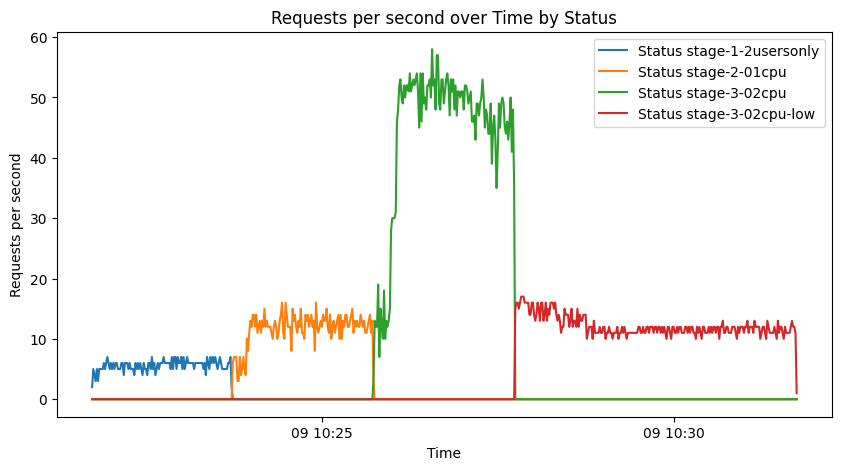

In [40]:
import csv
from collections import defaultdict
from itertools import chain
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

# get all files in the results folder
# sort them by timestamp
# get the last one


responses_per_second = defaultdict(lambda: defaultdict(int))

with open(filename_results, 'r') as csvfile:
    reader = csv.reader(csvfile)

    # Skip the header row
    next(reader)

    for row in reader:
        timestamp_str = row[1]
        status = row[2]

        timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S.%f")
        one_second_res = timestamp.replace(microsecond=0)
        responses_per_second[status][one_second_res] += 1

# Create a sorted list of unique timestamps across all status codes
all_timestamps = sorted(set(chain.from_iterable(time_counts.keys()
                        for time_counts in responses_per_second.values())))

# Fill in zeros for missing timestamps in each status code
for status, time_counts in responses_per_second.items():
    for t in all_timestamps:
        if t not in time_counts:
            time_counts[t] = 0

plt.figure(figsize=(10, 5))

for status, time_counts in responses_per_second.items():
    timestamps = sorted(time_counts.keys())
    request_counts = [time_counts[t] for t in timestamps]
    plt.plot(timestamps, request_counts, label=f'Status {status}')

plt.xlabel('Time')
plt.ylabel('Requests per second')
plt.title('Requests per second over Time by Status')
plt.legend()
# log scale
plt.show()

---

# DATA ANALYZER


In [ ]:
import os


def get_most_recent_benchmark_results(scenario_name):
    files = os.listdir(f"results/{scenario_name}")
    # filter only files with "metrics" in name
    files_results = [f for f in files if "results" in f]
    files_results.sort()
    return f"results/{scenario_name}/{files_results[-1]}"

In [ ]:
import pandas as pd


def convert_results_data(csv_path):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path, header=None)

    # Rename the columns
    df.columns = [
        "start_time", "end_time", "stage", "status_code", "response_data"
    ]

    # Initialize lists to store the extracted data
    stage_1_processing_times = []
    stage_2_processing_times = []
    stage_3_processing_times = []
    stage_1_latency_starts = []
    stage_2_latency_starts = []
    stage_3_latency_starts = []
    stage_1_latency_responses = []
    stage_2_latency_responses = []
    stage_3_latency_responses = []
    stage_1_totals = []
    stage_2_totals = []
    stage_3_totals = []

    # Process each row of the DataFrame
    for index, row in df.iterrows():
      # Check if the status code is 200
        if row["status_code"] == 200:
            # Extract the required data from the response_data column
            response_data = eval(row["response_data"])
            timestamps = response_data["data"]["timestamps"]

            # Calculate the stage processing times
            stage_1_processing_time = timestamps["send_2"] - \
                timestamps["start_1"]
            stage_2_processing_time = timestamps["end_2"] - \
                timestamps["start_2"]
            stage_3_processing_time = timestamps["end_3"] - \
                timestamps["start_3"]

            # Calculate the stage latencies
            stage_1_latency_start = timestamps["start_1"] - pd.to_datetime(
                row["start_time"], format='%Y-%m-%d %H:%M:%S.%f').timestamp()
            stage_2_latency_start = timestamps["start_2"] - \
                timestamps["send_2"]
            stage_3_latency_start = timestamps["start_3"] - \
                timestamps["send_3"]
            stage_1_latency_response = pd.to_datetime(
                row["end_time"], format='%Y-%m-%d %H:%M:%S.%f').timestamp() - timestamps["end_1"]
            stage_2_latency_response = timestamps["receive_2"] - \
                timestamps["end_2"]
            stage_3_latency_response = timestamps["receive_3"] - \
                timestamps["end_3"]

            # Calculate the total times for each stage
            stage_1_total = timestamps["end_1"] - timestamps["start_1"]
            stage_2_total = timestamps["receive_2"] - timestamps["send_2"]
            stage_3_total = timestamps["receive_3"] - timestamps["send_3"]

        else:
            # Set stage processing times to None
            stage_1_processing_time = None
            stage_2_processing_time = None
            stage_3_processing_time = None

            # Set stage latencies to None
            stage_1_latency_start = None
            stage_2_latency_start = None
            stage_3_latency_start = None

            stage_1_latency_response = None
            stage_2_latency_response = None
            stage_3_latency_response = None

            # Set total times for each stage to None
            stage_1_total = None
            stage_2_total = None
            stage_3_total = None

#       # Append the extracted data to the lists
        stage_1_processing_times.append(stage_1_processing_time)
        stage_2_processing_times.append(stage_2_processing_time)
        stage_3_processing_times.append(stage_3_processing_time)
        stage_1_latency_starts.append(stage_1_latency_start)
        stage_2_latency_starts.append(stage_2_latency_start)
        stage_3_latency_starts.append(stage_3_latency_start)
        stage_1_latency_responses.append(stage_1_latency_response)
        stage_2_latency_responses.append(stage_2_latency_response)
        stage_3_latency_responses.append(stage_3_latency_response)
        stage_1_totals.append(stage_1_total)
        stage_2_totals.append(stage_2_total)
        stage_3_totals.append(stage_3_total)

#   # Create a new DataFrame with the extracted data
    new_df = pd.DataFrame({
        "start_time": pd.to_datetime(df["start_time"], format='%Y-%m-%d %H:%M:%S.%f'),
        "total_time": pd.to_datetime(df["end_time"], format='%Y-%m-%d %H:%M:%S.%f') - pd.to_datetime(df["start_time"], format='%Y-%m-%d %H:%M:%S.%f'),
        "stage": df["stage"],
        "status_code": df["status_code"],
        "stage_1_processing_time": stage_1_processing_times,
        "stage_2_processing_time": stage_2_processing_times,
        "stage_3_processing_time": stage_3_processing_times,
        "stage_1_latency_start": stage_2_latency_starts,
        "stage_2_latency_start": stage_2_latency_starts,
        "stage_3_latency_start": stage_3_latency_starts,
        "stage_1_latency_response": stage_2_latency_responses,
        "stage_2_latency_response": stage_2_latency_responses,
        "stage_3_latency_response": stage_3_latency_responses,
        "stage_1_total": stage_1_totals,
        "stage_2_total": stage_2_totals,
        "stage_3_total": stage_3_totals,
    })
    return new_df


# Convert the CSV to a DataFrame
csv_path = get_most_recent_benchmark_results('scenario-1')
df = convert_results_data(csv_path)

# Print the resulting DataFrame
df

In [ ]:
results_df

In [ ]:
from data_aggregator import DataAggregator
import pandas as pd
import matplotlib.pyplot as plt


aggregator = DataAggregator("scenario-1")
results_df = aggregator.convert_results_data(
    aggregator.get_most_recent_benchmark_results())


def plot_results_mean_processing_aggregated_chart(df):

    # Convert 'start_time' column to DateTime type
    df['start_time'] = pd.to_datetime(df['start_time'])

    # order by timestamp and get the earliest timestamp and name for each stage
    stage_start_times = df.sort_values(by='start_time').groupby(
        'stage').first().reset_index()[['stage', 'start_time']]

    # drop stage column
    df.drop('stage', axis=1, inplace=True)

    # Set 'start_time' as the DataFrame index
    df.set_index('start_time', inplace=True)

    # Resample the data in 2-second batches and calculate the mean
    df_resampled = df.resample('2S').mean()

    df_resampled['total_time'] = df_resampled['total_time'] / 1e6

    # # Plot the line chart
    plt.figure(figsize=(12, 8))

    # Plot dotted lines for stage 1, stage 2, and stage 3 processing time
    plt.plot(df_resampled.index,
             df_resampled['stage_1_processing_time'], 'r:', label='Stage 1 Calculations Time')
    plt.plot(df_resampled.index,
             df_resampled['stage_2_processing_time'], 'g:', label='Stage 2 Calculations Time')
    plt.plot(df_resampled.index,
             df_resampled['stage_3_processing_time'], 'b:', label='Stage 3 Calculations Time')

    # Plot lines with corresponding colors for total stage 1, stage 2, and stage 3 processing times
    plt.plot(df_resampled.index,
             df_resampled['stage_1_total'], 'r', label='Total Stage 1 Time')
    plt.plot(df_resampled.index,
             df_resampled['stage_2_total'], 'g', label='Total Stage 2 Time (REQ to RES)')
    plt.plot(df_resampled.index,
             df_resampled['stage_3_total'], 'b', label='Total Stage 3 Time (REQ to RES)')

    # Plot lines for 'total_time'
    plt.plot(df_resampled.index,
             df_resampled['total_time'], 'k', label='Total Time')

    # Plot vertical lines for the stage start times
    for _, row in stage_start_times.iterrows():
        plt.axvline(row['start_time'], color='gray', linestyle='--')

    #  log scale for y axis
    plt.yscale('log')

    plt.xlabel('Time')
    plt.ylabel('Processing Time (miliseconds)')
    plt.title('Aggregated Mean Processing Times')
    plt.legend()
    plt.show()


plot_results_mean_latency_aggregated_chart(results_df)

In [ ]:
plot_results_mean_latency_aggregated_chart

## Metrics


In [ ]:
import os


def get_most_recent_benchmark_metrics(scenario_name):
    files = os.listdir(f"results/{scenario_name}")
    # filter only files with "metrics" in name
    files_results = [f for f in files if "metrics" in f]
    files_results.sort()
    return f"results/{scenario_name}/{files_results[-1]}"

In [ ]:
import pandas as pd

csv_path = get_most_recent_benchmark_metrics('scenario-1')


def convert_cluster_metrics(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path, header=None)

    # Set column names
    df.columns = ['timestamp', 'cluster', 'stage',
                  'metric_name', 'metric_value', 'metadata']

    # Filter out rows with metadata
    df_filtered = df[df['metadata'] == '{}']

    # Pivot the DataFrame to have each metric as a separate column
    df_pivoted = df_filtered.pivot_table(
        index=['timestamp', 'cluster'], columns='metric_name', values='metric_value').reset_index()
    return df_pivoted


df = convert_cluster_metrics(csv_path)
df

In [ ]:
import pandas as pd

csv_path = get_most_recent_benchmark_metrics('scenario-1')


def convert_knative_metrics(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path, header=None)

    # Set column names
    df.columns = ['timestamp', 'cluster', 'stage',
                  'metric_name', 'metric_value', 'metadata']

    df = df[df['metadata'] != '{}']

    # Extract desired columns using eval()
    metadata_dict = [eval(meta) for meta in df['metadata']]
    df['service'] = [meta.get('service_name') for meta in metadata_dict]
    df['revision'] = [meta.get('revision_name').split('-')[-1]
                      for meta in metadata_dict]

    # Select only the desired columns
    df = df[['timestamp', 'stage', 'metric_name',
             'metric_value', 'service', 'revision']]
    return df


df = convert_knative_metrics(csv_path)
df

In [ ]:
import os
import pandas as pd


def get_most_recent_benchmark_results(scenario_name):
    files = os.listdir(f"results/{scenario_name}")
    # filter only files with "metrics" in name
    files_results = [f for f in files if "results" in f]
    files_results.sort()
    return f"results/{scenario_name}/{files_results[-1]}"


def get_most_recent_benchmark_metrics(scenario_name):
    files = os.listdir(f"results/{scenario_name}")
    # filter only files with "metrics" in name
    files_results = [f for f in files if "metrics" in f]
    files_results.sort()
    return f"results/{scenario_name}/{files_results[-1]}"


def convert_results_data(csv_path):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path, header=None)

    # Rename the columns
    df.columns = [
        "start_time", "end_time", "stage", "status_code", "response_data"
    ]

    # Initialize lists to store the extracted data
    stage_1_processing_times = []
    stage_2_processing_times = []
    stage_3_processing_times = []
    stage_1_latency_starts = []
    stage_2_latency_starts = []
    stage_3_latency_starts = []
    stage_1_latency_responses = []
    stage_2_latency_responses = []
    stage_3_latency_responses = []
    stage_1_totals = []
    stage_2_totals = []
    stage_3_totals = []

    # Process each row of the DataFrame
    for index, row in df.iterrows():
      # Check if the status code is 200
        if row["status_code"] == 200:
            # Extract the required data from the response_data column
            response_data = eval(row["response_data"])
            timestamps = response_data["data"]["timestamps"]

            # Calculate the stage processing times
            stage_1_processing_time = timestamps["send_2"] - \
                timestamps["start_1"]
            stage_2_processing_time = timestamps["end_2"] - \
                timestamps["start_2"]
            stage_3_processing_time = timestamps["end_3"] - \
                timestamps["start_3"]

            # Calculate the stage latencies
            stage_1_latency_start = timestamps["start_1"] - pd.to_datetime(
                row["start_time"], format='%Y-%m-%d %H:%M:%S.%f').timestamp()
            stage_2_latency_start = timestamps["start_2"] - \
                timestamps["send_2"]
            stage_3_latency_start = timestamps["start_3"] - \
                timestamps["send_3"]
            stage_1_latency_response = pd.to_datetime(
                row["end_time"], format='%Y-%m-%d %H:%M:%S.%f').timestamp() - timestamps["end_1"]
            stage_2_latency_response = timestamps["receive_2"] - \
                timestamps["end_2"]
            stage_3_latency_response = timestamps["receive_3"] - \
                timestamps["end_3"]

            # Calculate the total times for each stage
            stage_1_total = timestamps["end_1"] - timestamps["start_1"]
            stage_2_total = timestamps["receive_2"] - timestamps["send_2"]
            stage_3_total = timestamps["receive_3"] - timestamps["send_3"]

        else:
            # Set stage processing times to None
            stage_1_processing_time = None
            stage_2_processing_time = None
            stage_3_processing_time = None

            # Set stage latencies to None
            stage_1_latency_start = None
            stage_2_latency_start = None
            stage_3_latency_start = None

            stage_1_latency_response = None
            stage_2_latency_response = None
            stage_3_latency_response = None

            # Set total times for each stage to None
            stage_1_total = None
            stage_2_total = None
            stage_3_total = None

#       # Append the extracted data to the lists
        stage_1_processing_times.append(stage_1_processing_time)
        stage_2_processing_times.append(stage_2_processing_time)
        stage_3_processing_times.append(stage_3_processing_time)
        stage_1_latency_starts.append(stage_1_latency_start)
        stage_2_latency_starts.append(stage_2_latency_start)
        stage_3_latency_starts.append(stage_3_latency_start)
        stage_1_latency_responses.append(stage_1_latency_response)
        stage_2_latency_responses.append(stage_2_latency_response)
        stage_3_latency_responses.append(stage_3_latency_response)
        stage_1_totals.append(stage_1_total)
        stage_2_totals.append(stage_2_total)
        stage_3_totals.append(stage_3_total)

#   # Create a new DataFrame with the extracted data
    new_df = pd.DataFrame({
        "start_time": pd.to_datetime(df["start_time"], format='%Y-%m-%d %H:%M:%S.%f'),
        "total_time": pd.to_datetime(df["end_time"], format='%Y-%m-%d %H:%M:%S.%f') - pd.to_datetime(df["start_time"], format='%Y-%m-%d %H:%M:%S.%f'),
        "stage": df["stage"],
        "status_code": df["status_code"],
        "stage_1_processing_time": stage_1_processing_times,
        "stage_2_processing_time": stage_2_processing_times,
        "stage_3_processing_time": stage_3_processing_times,
        "stage_1_latency_start": stage_2_latency_starts,
        "stage_2_latency_start": stage_2_latency_starts,
        "stage_3_latency_start": stage_3_latency_starts,
        "stage_1_latency_response": stage_2_latency_responses,
        "stage_2_latency_response": stage_2_latency_responses,
        "stage_3_latency_response": stage_3_latency_responses,
        "stage_1_total": stage_1_totals,
        "stage_2_total": stage_2_totals,
        "stage_3_total": stage_3_totals,
    })
    return new_df


def convert_cluster_metrics(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path, header=None)

    # Set column names
    df.columns = ['timestamp', 'cluster', 'stage',
                  'metric_name', 'metric_value', 'metadata']

    # Filter out rows with metadata
    df_filtered = df[df['metadata'] == '{}']

    # Pivot the DataFrame to have each metric as a separate column
    df_pivoted = df_filtered.pivot_table(
        index=['timestamp', 'cluster'], columns='metric_name', values='metric_value').reset_index()
    return df_pivoted


def convert_knative_metrics(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path, header=None)

    # Set column names
    df.columns = ['timestamp', 'cluster', 'stage',
                  'metric_name', 'metric_value', 'metadata']

    df = df[df['metadata'] != '{}']

    # Extract desired columns using eval()
    metadata_dict = [eval(meta) for meta in df['metadata']]
    df['service'] = [meta.get('service_name') for meta in metadata_dict]
    df['revision'] = [meta.get('revision_name').split('-')[-1]
                      for meta in metadata_dict]

    # Select only the desired columns
    df = df[['timestamp', 'stage', 'metric_name',
             'metric_value', 'service', 'revision']]
    return df

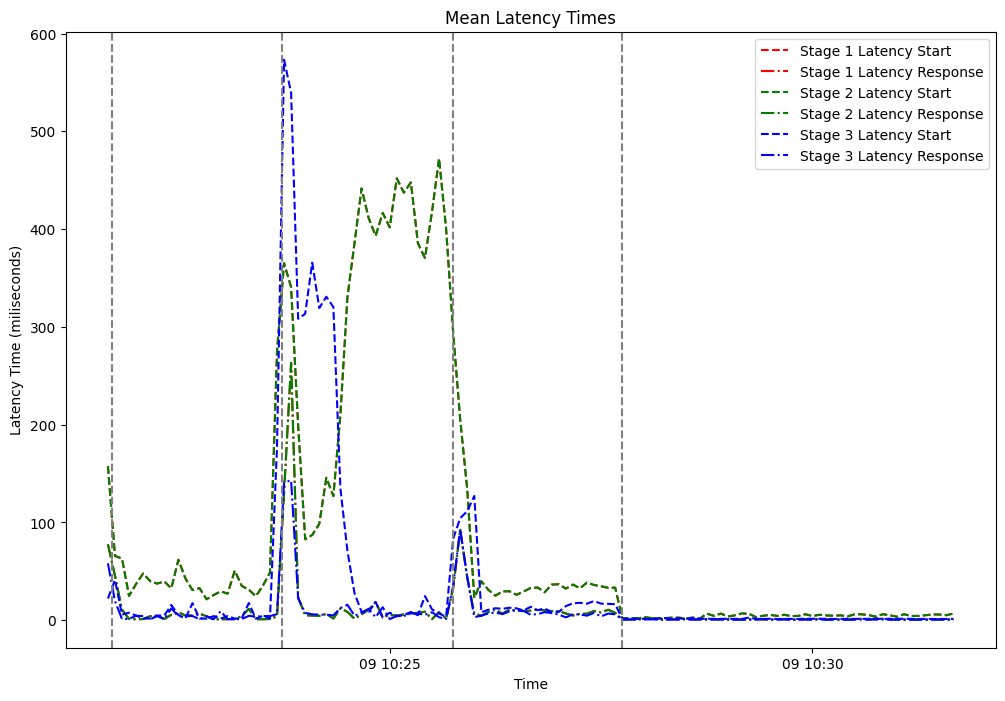

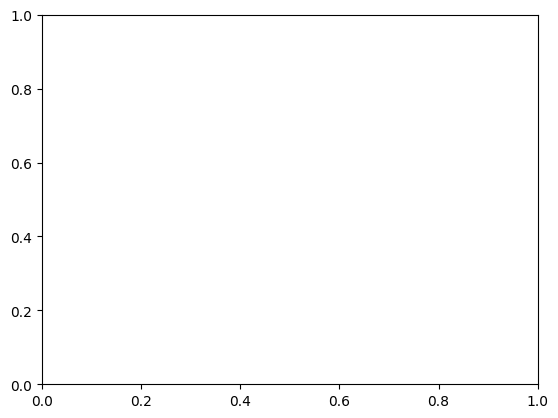

In [2]:
from visualizer.visualizer import Visualizer
from data_aggregator import DataAggregator


aggregator = DataAggregator("scenario-1")
results_df = aggregator.convert_results_data(
    aggregator.get_most_recent_benchmark_results())
cluster_metrics_df = aggregator.convert_cluster_metrics(
    aggregator.get_most_recent_benchmark_metrics())
knative_metrics_df = aggregator.convert_knative_metrics(
    aggregator.get_most_recent_benchmark_metrics())

visualizer = Visualizer(results_df, cluster_metrics_df,
                        knative_metrics_df, "scenario-1")
visualizer.plot_results_mean_latency_aggregated_chart()

------
---


In [33]:
def plot_knative_metrics(df):
    # Convert 'timestamp' column to DateTime type
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Group the data by 'service', 'metric_name', and 'timestamp' and calculate the sum of 'metric_value'
    grouped = df.groupby(
        ['service', 'metric_name', 'timestamp']).sum().reset_index()

    # Get unique services and assign a color to each service
    services = grouped['service'].unique()
    colors = ['red', 'green', 'blue', 'orange']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot lines for each service and metric
    for service, color in zip(services, colors):
        service_group = grouped[grouped['service'] == service]

        # Get unique metrics within the service and assign a line style to each metric
        metrics = service_group['metric_name'].unique()

        line_styles = ['-', '--', '-.', ':']

        # Plot lines for each metric within the service
        for metric, style in zip(metrics, line_styles):
            metric_group = service_group[service_group['metric_name'] == metric]
            ax.plot(metric_group['timestamp'], metric_group['metric_value'],
                    linestyle=style, color=color, label=f'{service} - {metric}')

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Metric Value')
    ax.set_title('Sum of Metrics by Service and Metric')

    # Add a legend
    ax.legend()

    plt.show()

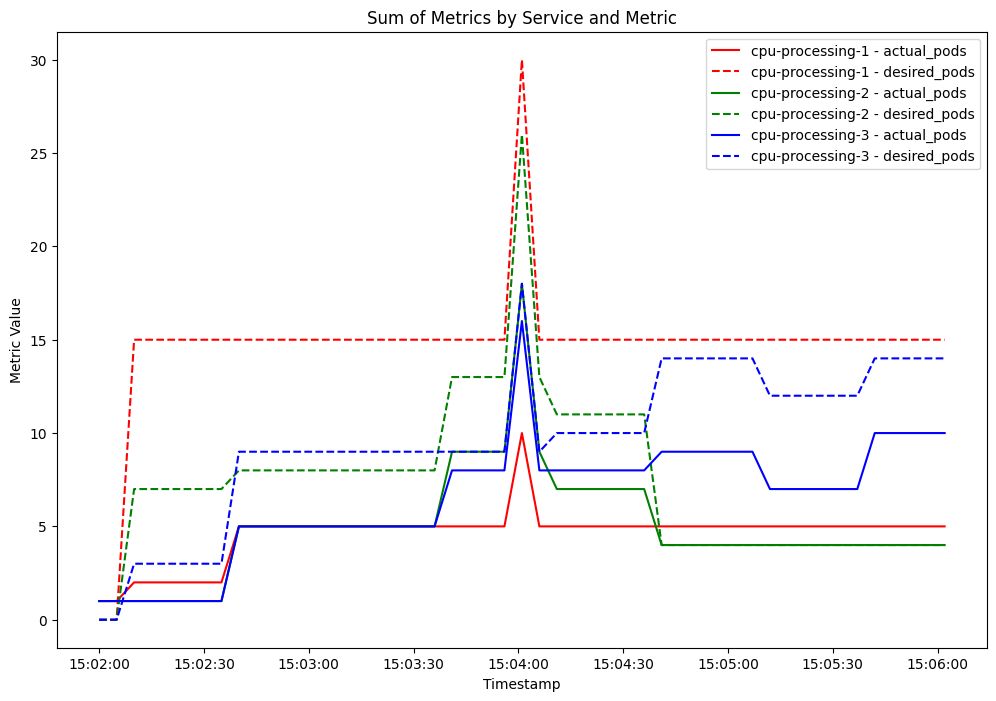

In [34]:
from config_manager import ConfigManager
from data_aggregator.data_aggregator import DataAggregator
from resource_provisioner import ResourceProvisioner
from benchmarking_orchestrator import BenchmarkingOrchestrator
from metrics_collector import MetricsCollector

from visualizer import Visualizer

import pandas as pd
import matplotlib.pyplot as plt


aggregator = DataAggregator("increasing_stage_2_and_3_containers")
visualizer = Visualizer(aggregator)
plot_knative_metrics(aggregator.knative_metrics_df)

# # visualizer.visualize()
# df.to_csv("increasing_stage_2_and_3_containers.csv", index=False)

In [18]:
def calculate_throughtput(df):

    df.drop('stage', axis=1, inplace=True)
    # Convert 'start_time' column to DateTime type
    df['start_time'] = pd.to_datetime(df['start_time'])

    # Set 'start_time' as the DataFrame index
    df.set_index('start_time', inplace=True)

    # Resample the data in 1-second intervals and count the number of requests for each response code
    df_resampled = df.resample(
        '1S')['status_code'].value_counts().unstack(fill_value=0)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot lines for each response code
    for code in df_resampled.columns:
        ax.plot(df_resampled.index,
                df_resampled[code], label=f'Response Code: {code}')

    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Requests')
    ax.set_title('Number of Requests in Each Second by Response Code')

    # Add a legend
    ax.legend()

    plt.show()

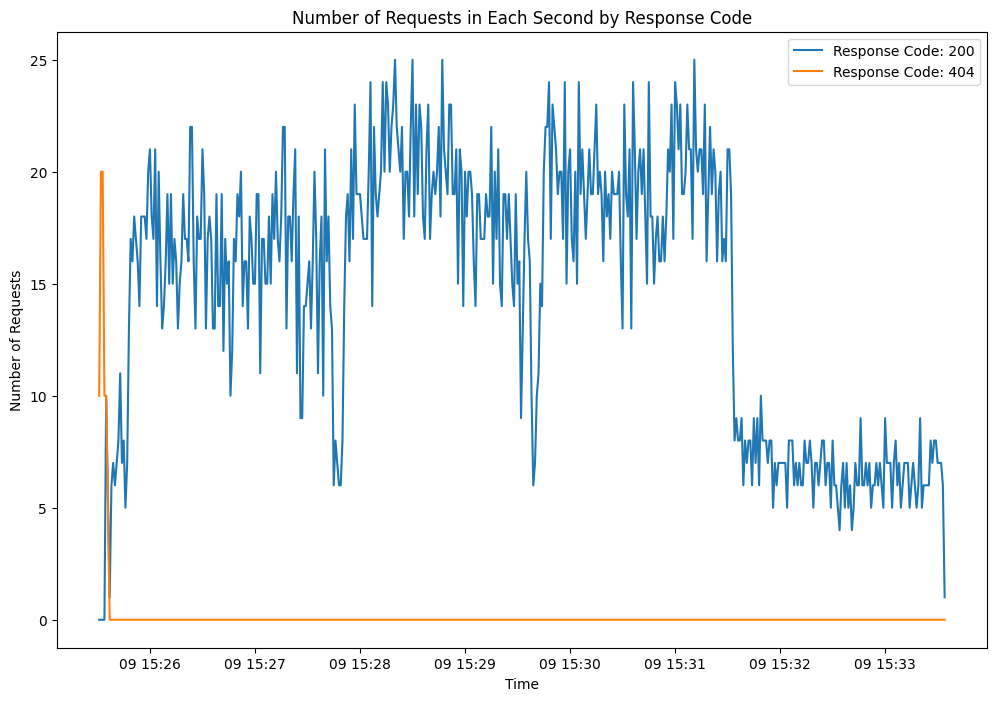

In [19]:
from config_manager import ConfigManager
from data_aggregator.data_aggregator import DataAggregator
from resource_provisioner import ResourceProvisioner
from benchmarking_orchestrator import BenchmarkingOrchestrator
from metrics_collector import MetricsCollector

from visualizer import Visualizer

import pandas as pd
import matplotlib.pyplot as plt


aggregator = DataAggregator("increasing_stage_2_and_3_containers")
visualizer = Visualizer(aggregator)
aggregator.results_df.to_csv(
    "increasing_stage_2_and_3_containers.csv", index=False)
# plot_cluster_metrics(aggregator.cluster_metrics_df)
calculate_throughtput(aggregator.results_df)

# # visualizer.visualize()
# df.to_csv("increasing_stage_2_and_3_containers.csv", index=False)

In [ ]:
aggregator.knative_metrics_df

,timestamp,stage,metric_name,metric_value,service,revision
26,2023-06-09 15:02:00,5-5-5,actual_pods,1.0,cpu-processing-1,00001
27,2023-06-09 15:02:05,5-5-5,actual_pods,1.0,cpu-processing-1,00001
28,2023-06-09 15:02:10,5-5-5,actual_pods,2.0,cpu-processing-1,00001
29,2023-06-09 15:02:15,5-5-5,actual_pods,2.0,cpu-processing-1,00001
30,2023-06-09 15:02:20,5-5-5,actual_pods,2.0,cpu-processing-1,00001
...,...,...,...,...,...,...
611,2023-06-09 15:05:42,5-6-8,desired_pods,12.0,cpu-processing-3,00004
612,2023-06-09 15:05:47,5-6-8,desired_pods,12.0,cpu-processing-3,00004
613,2023-06-09 15:05:52,5-6-8,desired_pods,12.0,cpu-processing-3,00004
614,2023-06-09 15:05:57,5-6-8,desired_pods,12.0,cpu-processing-3,00004


---


In [6]:
from data_aggregator import DataAggregator

aggregator = DataAggregator("hybrid-serverless-2")
res = aggregator.results_df
res

,start_time,total_time,stage,status_code,stage_1_processing_time,stage_2_processing_time,stage_3_processing_time,stage_1_latency_start,stage_2_latency_start,stage_3_latency_start,stage_1_latency_response,stage_2_latency_response,stage_3_latency_response,stage_1_total,stage_2_total,stage_3_total
0,2023-06-09 20:29:28.152172,0 days 00:00:00.023931,edge_only,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-09 20:29:28.676992,0 days 00:00:00.018335,edge_only,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-09 20:29:29.197629,0 days 00:00:00.015297,edge_only,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-09 20:29:29.714084,0 days 00:00:00.014520,edge_only,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-09 20:29:30.233810,0 days 00:00:00.013692,edge_only,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21447,2023-06-09 20:41:28.978133,0 days 00:00:00.080375,1_edge_2_3_cluster_max_containers,200,23.0,12.0,12.0,9.0,9.0,4.0,2.0,2.0,3.0,65.0,23.0,19.0
21448,2023-06-09 20:41:29.058538,0 days 00:00:00.076883,1_edge_2_3_cluster_max_containers,200,25.0,12.0,12.0,4.0,4.0,2.0,3.0,3.0,2.0,61.0,19.0,16.0
21449,2023-06-09 20:41:29.135478,0 days 00:00:00.078839,1_edge_2_3_cluster_max_containers,200,27.0,12.0,13.0,2.0,2.0,3.0,3.0,3.0,2.0,63.0,17.0,18.0
21450,2023-06-09 20:41:29.214371,0 days 00:00:00.077363,1_edge_2_3_cluster_max_containers,200,29.0,12.0,13.0,2.0,2.0,1.0,3.0,3.0,2.0,62.0,17.0,16.0


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# res.to_csv("hybrid-serverless-2.csv", index=False)

1_edge_2_3_cluster [[112.  38.  39.]
 [405. 149. 163.]
 [454. 333.  20.]
 ...
 [ 60.  18.  17.]
 [ 88.  46.  17.]
 [ 89.  44.  17.]]
1_edge_2_3_cluster_max_containers [[ 57.  17.  16.]
 [245.  98.  17.]
 [ 65.  23.  17.]
 ...
 [ 63.  17.  18.]
 [ 62.  17.  16.]
 [ 58.  17.  16.]]
edge_only [[168.  32. 110.]
 [181.  85.  68.]
 [216. 127.  58.]
 ...
 [106.  50.  31.]
 [ 94.  37.  34.]
 [ 86.  30.  31.]]
1_edge_2_3_cluster [[ 33.  25.  29.]
 [ 91.  14.  13.]
 [100.  14.  12.]
 ...
 [ 25.  12.  12.]
 [ 25.  13.  13.]
 [ 27.  13.  12.]]
1_edge_2_3_cluster_max_containers [[ 24.  13.  12.]
 [129.  12.  12.]
 [ 25.  12.  12.]
 ...
 [ 27.  12.  13.]
 [ 29.  12.  13.]
 [ 24.  12.  12.]]
edge_only [[25. 24. 29.]
 [26. 38. 26.]
 [29. 85. 39.]
 ...
 [24. 42. 26.]
 [23. 29. 27.]
 [24. 25. 24.]]
1_edge_2_3_cluster [[ 3.  3.  2.]
 [26. 26. 13.]
 [ 4.  4.  4.]
 ...
 [ 4.  4.  3.]
 [ 4.  4.  3.]
 [ 3.  3.  3.]]
1_edge_2_3_cluster_max_containers [[3. 3. 3.]
 [3. 3. 4.]
 [6. 6. 3.]
 ...
 [3. 3. 2.]
 [3. 3

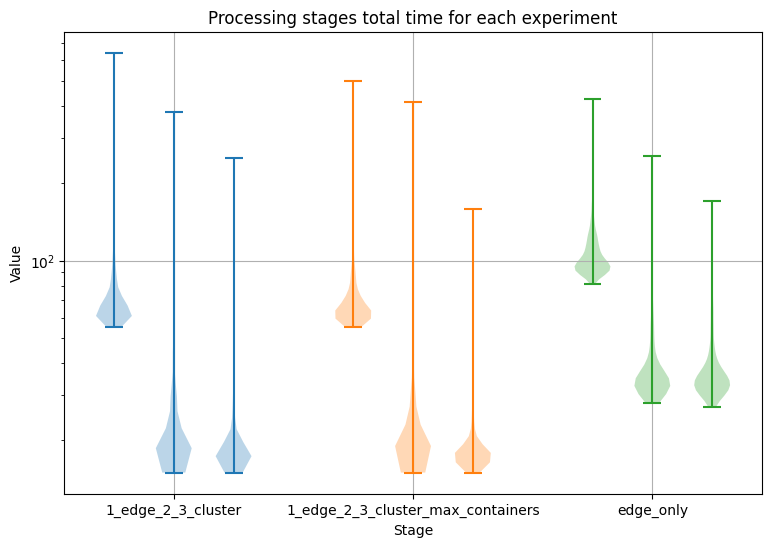

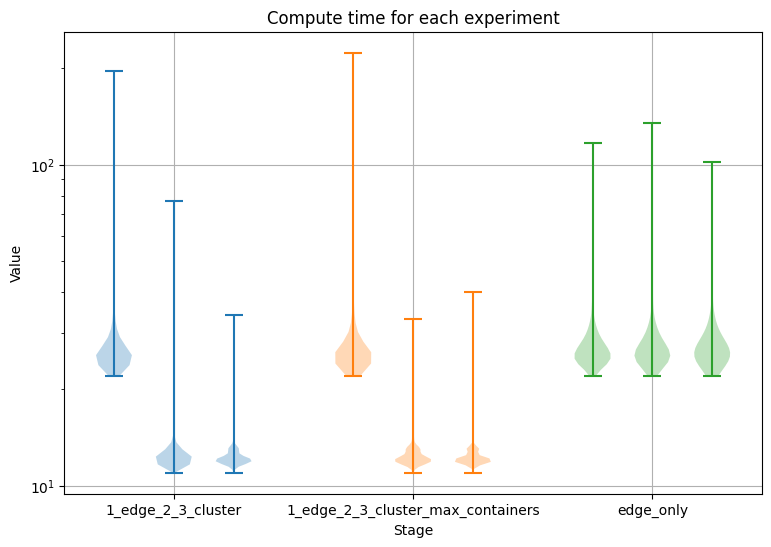

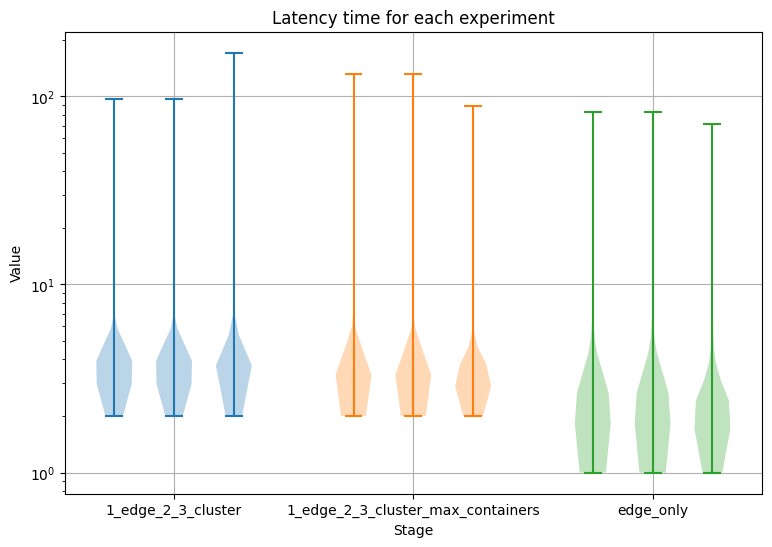

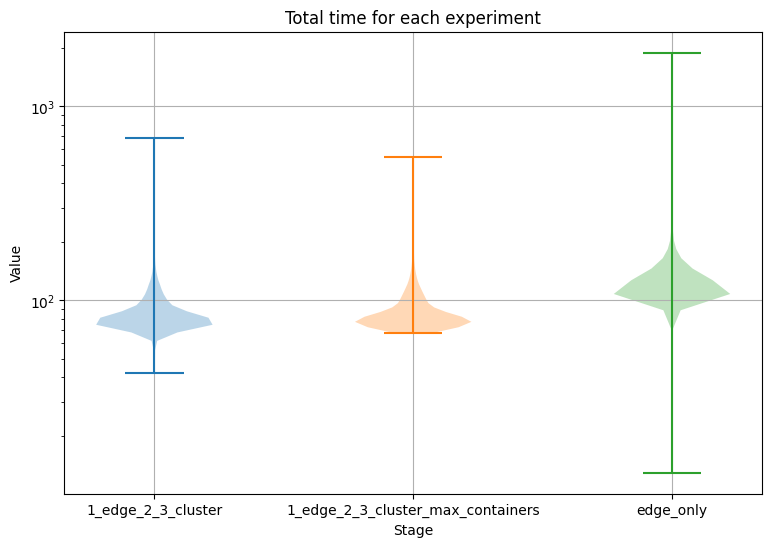

In [60]:
def print_box_plots_for_stages(input_df, columns, title, filename):
    df = input_df.copy()
    df['total_time'] = pd.to_timedelta(df['total_time'])
    df['total_time_ms'] = df['total_time'].dt.total_seconds() * 1000

    grouped_df = df.dropna(subset=columns).groupby(
        'stage')[columns]

    # Build the box plot
    fig, ax = plt.subplots(figsize=(9, 6))

    # For each group, plot
    for i, (stage, data) in enumerate(grouped_df):
        ax.violinplot(data.values, positions=[i*4+j for j in range(len(columns))], widths=9/(len(columns)*5),
                      #    boxprops=dict(color="darkblue"),

                      #    flierprops=dict(markerfacecolor="darkblue", markeredgecolor="darkblue",
                      #                    marker='o', markersize=3, linestyle='none'),
                      #    labels=columns
                      )

    # Set stage names as xticklabels
    ax.set_xticks([i*4+(len(columns)//2) for i in range(len(grouped_df))])
    ax.set_xticklabels(grouped_df.groups.keys())

    # lgo scale
    ax.set_yscale('log')

    plt.xlabel('Stage')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    # plt.show()
    plt.savefig(filename + ".png")


print_box_plots_for_stages(res, ['stage_1_total', 'stage_2_total', 'stage_3_total'],
                           'Processing stages total time for each experiment', 'stages_total_time')

print_box_plots_for_stages(res, ['stage_1_processing_time', 'stage_2_processing_time',
                           'stage_3_processing_time'], "Compute time for each experiment", 'stages_compute_time')

print_box_plots_for_stages(res, ['stage_1_latency_response', 'stage_2_latency_response', 'stage_3_latency_response'],
                           "Latency time for each experiment", 'stages_latency_time')

print_box_plots_for_stages(res, ['total_time_ms'],
                           "Total time for each experiment", 'total_time_ms')